In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# Define the ResNet block
def resnet_block(x, filters, stride):
    y = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filters, 3, padding='same')(y)
    y = layers.BatchNormalization()(y)

    if stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(x)
    else:
        shortcut = x

    shortcut = layers.BatchNormalization()(shortcut)

    y = layers.Add()([y, shortcut])
    y = layers.Activation('relu')(y)

    return y

# Define the ResNet model
def resnet_model(num_classes):
    inputs = keras.Input(shape=(224, 224, 3))

    x = layers.Conv2D(64, 7, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 128, 2)
    x = resnet_block(x, 256, 2)
    x = resnet_block(x, 512, 2)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, x)
    return model

# Define the data generators
train_dir = 'data_split/train'
validation_dir = 'data_split/validation'
testing_dir = 'data_split/test'

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testing_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
testing_generator = testing_datagen.flow_from_directory(testing_dir, target_size=(224, 224), batch_size=1, class_mode=None, shuffle=False)

# Compile the model
model = resnet_model(4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, steps_per_epoch=train_generator.samples // 32, epochs=10, validation_data=validation_generator, validation_steps=validation_generator.samples // 32)


# Make predictions on the testing set
testing_predictions = model.predict(testing_generator, steps=testing_generator.samples)

# Get the class predictions
testing_class_predictions = tf.argmax(testing_predictions, axis=1)

# Print the class predictions
print(testing_class_predictions)

Found 304 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/10
9/9 [==============================] - 17s 2s/step - loss: 1.4510 - accuracy: 0.5257 - val_loss: 2.5164 - val_accuracy: 0.2500
Epoch 2/10
9/9 [==============================] - 14s 2s/step - loss: 0.7561 - accuracy: 0.7014 - val_loss: 3.8843 - val_accuracy: 0.2188
Epoch 3/10
9/9 [==============================] - 14s 1s/step - loss: 0.7103 - accuracy: 0.7169 - val_loss: 1.1000 - val_accuracy: 0.5156
Epoch 4/10
9/9 [==============================] - 14s 1s/step - loss: 0.5533 - accuracy: 0.7757 - val_loss: 2.3089 - val_accuracy: 0.2812
Epoch 5/10
9/9 [==============================] - 14s 1s/step - loss: 0.4627 - accuracy: 0.8456 - val_loss: 1.7428 - val_accuracy: 0.5625
Epoch 6/10
9/9 [==============================] - 14s 2s/step - loss: 0.2650 - accuracy: 0.9044 - val_loss: 2.2791 - val_accuracy: 0.2969
Epoch 7/10
9/9 [==============================] - 1

Found 304 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 3.1747 - accuracy: 0.4375 - val_loss: 3.0488 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 14s 1s/step - loss: 2.8545 - accuracy: 0.5147 - val_loss: 3.5433 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 14s 2s/step - loss: 2.6086 - accuracy: 0.6397 - val_loss: 3.1249 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 15s 2s/step - loss: 2.5746 - accuracy: 0.6667 - val_loss: 2.8685 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 14s 1s/step - loss: 2.5384 - accuracy: 0.6324 - val_loss: 3.8043 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 14s 1s/step - loss: 2.4346 - accuracy: 0.6434 - val_loss: 3.1124 - val_acc

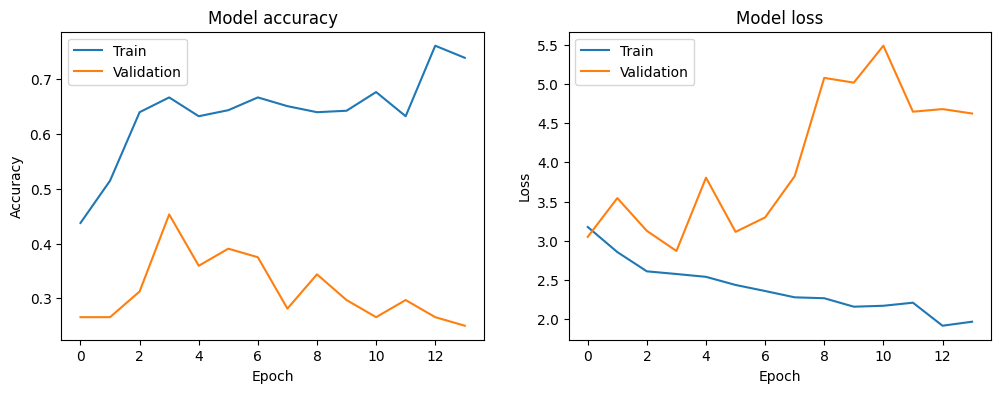

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import os
import matplotlib.pyplot as plt
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define the ResNet block
def resnet_block(x, filters, stride):
    y = layers.Conv2D(filters, 3, strides=stride, padding='same', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)

    y = layers.Conv2D(filters, 3, padding='same', kernel_regularizer=keras.regularizers.l2(0.001))(y)
    y = layers.BatchNormalization()(y)

    if stride != 1:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(x)
    else:
        shortcut = x

    shortcut = layers.BatchNormalization()(shortcut)

    y = layers.Add()([y, shortcut])
    y = layers.Activation('relu')(y)

    return y

# Define the ResNet model
def resnet_model(num_classes):
    inputs = keras.Input(shape=(224, 224, 3))

    x = layers.Conv2D(64, 7, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = resnet_block(x, 64, 2)
    x = resnet_block(x, 128, 2)
    x = resnet_block(x, 256, 2)
    x = resnet_block(x, 512, 2)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Add dropout to prevent overfitting
    x = layers.Dense(num_classes, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.001))(x)

    model = keras.Model(inputs, x)
    return model



# Paths
data_dir = 'dataset_18'
train_dir = 'data_split/train'
validation_dir = 'data_split/validation'
testing_dir = 'data_split/test'

# Ensure directories exist
for dir_path in [train_dir, validation_dir, testing_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Split data
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)
        
        # Copy files to train folder
        train_category_dir = os.path.join(train_dir, category)
        if not os.path.exists(train_category_dir):
            os.makedirs(train_category_dir)
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_category_dir, img))
        
        # Copy files to validation folder
        val_category_dir = os.path.join(validation_dir, category)
        if not os.path.exists(val_category_dir):
            os.makedirs(val_category_dir)
        for img in val_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_category_dir, img))
        
        # Copy files to test folder
        test_category_dir = os.path.join(testing_dir, category)
        if not os.path.exists(test_category_dir):
            os.makedirs(test_category_dir)
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_category_dir, img))

# Define the data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
testing_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
testing_generator = testing_datagen.flow_from_directory(testing_dir, target_size=(224, 224), batch_size=1, class_mode=None, shuffle=False)

# Compile and train your model as before

# Compile the model
model = resnet_model(4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples // 32, 
    epochs=50, 
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, lr_scheduler]
)

# Make predictions on the testing set
testing_predictions = model.predict(testing_generator, steps=testing_generator.samples)

# Get the class predictions
testing_class_predictions = tf.argmax(testing_predictions, axis=1)

# Print the class predictions
print(testing_class_predictions)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Found 304 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/50
9/9 [==============================] - 13s 1s/step - loss: 1.8088 - accuracy: 0.2794 - val_loss: 1.3812 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 2/50
9/9 [==============================] - 10s 1s/step - loss: 1.5437 - accuracy: 0.2794 - val_loss: 1.4087 - val_accuracy: 0.2344 - lr: 0.0010
Epoch 3/50
9/9 [==============================] - 10s 1s/step - loss: 1.5051 - accuracy: 0.2831 - val_loss: 1.3502 - val_accuracy: 0.3906 - lr: 0.0010
Epoch 4/50
9/9 [==============================] - 10s 1s/step - loss: 1.4963 - accuracy: 0.2574 - val_loss: 1.3185 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 1.4756 - accuracy: 0.2941 - val_loss: 1.3102 - val_accuracy: 0.4375 - lr: 0.0010
Epoch 6/50
9/9 [==============================] - 11s 1s/st

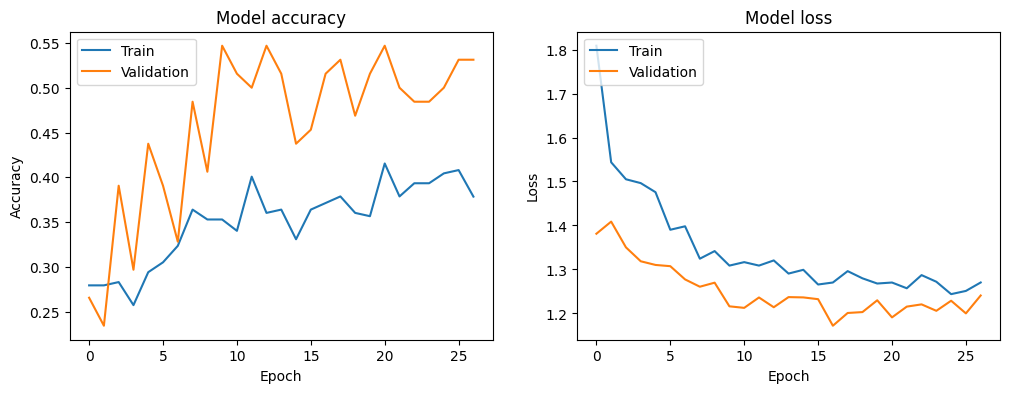

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
import os
import matplotlib.pyplot as plt
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Paths
data_dir = 'dataset_18'
train_dir = 'data_split/train'
validation_dir = 'data_split/validation'
testing_dir = 'data_split/test'

# Ensure directories exist
for dir_path in [train_dir, validation_dir, testing_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

# Split data
for category in os.listdir(data_dir):
    category_path = os.path.join(data_dir, category)
    if os.path.isdir(category_path):
        images = os.listdir(category_path)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)
        
        # Copy files to train folder
        train_category_dir = os.path.join(train_dir, category)
        if not os.path.exists(train_category_dir):
            os.makedirs(train_category_dir)
        for img in train_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_category_dir, img))
        
        # Copy files to validation folder
        val_category_dir = os.path.join(validation_dir, category)
        if not os.path.exists(val_category_dir):
            os.makedirs(val_category_dir)
        for img in val_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(val_category_dir, img))
        
        # Copy files to test folder
        test_category_dir = os.path.join(testing_dir, category)
        if not os.path.exists(test_category_dir):
            os.makedirs(test_category_dir)
        for img in test_images:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_category_dir, img))

# Define the data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
testing_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')
testing_generator = testing_datagen.flow_from_directory(testing_dir, target_size=(224, 224), batch_size=1, class_mode=None, shuffle=False)

# Define the pretrained ResNet model
def pretrained_resnet_model(num_classes):
    base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Add dropout to prevent overfitting
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

# Compile the model
model = pretrained_resnet_model(4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model
history = model.fit(
    train_generator, 
    steps_per_epoch=train_generator.samples // 32, 
    epochs=50, 
    validation_data=validation_generator, 
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping, reduce_lr, model_checkpoint, lr_scheduler]
)

# Make predictions on the testing set
testing_predictions = model.predict(testing_generator, steps=testing_generator.samples)

# Get the class predictions
testing_class_predictions = tf.argmax(testing_predictions, axis=1)

# Print the class predictions
print(testing_class_predictions)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
